---
电弧检测
---

## 1. **简介**
**用途**：通过电流、电压时间序列数据检测有无电弧

**原理**：通过提取特征来实现分类任务或变点检测

**检测方法**：使用机器学习方法来分类；利用MAD判断某一时刻的点是否为离群点，连续出现离群点认为是电路模式发生了改变

## 2.**数据集**
**github地址**：[IAED](https://github.com/inteverdata/IAED):Intever Public Database for Arcing Event Detection
InteverArcingDataSet-release1.

**发布时间**：2020年

**是否有标注**：是0

## 3.**代码**

### 3.1 导入必要模块

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from GetData import DataProcess
import statsmodels.api as sm
import time
import os
from PIL import Image
from sklearn.metrics import confusion_matrix

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

### 3.2 一些函数

In [2]:
# 该函数用以快速生成读取数据集需要的参数
def Easyget_path_and_windowsize_list(root_dir = os.getcwd(), suffix=None):
    """
    只针对该数据集，快速获取读取数据集需要的参数
    :param root_dir: 搜索的根目录
    :param suffix: 搜索的关键字
    :return: tuple,分别是数据集绝对路径的列表，以及建议窗口尺寸的列表
    """
    if suffix is None:
        suffix = ['m1', 'm2', 'm3']
    path_list = []

    for dirpath, dirnames, filenames in os.walk(root_dir):
        for dirname in dirnames:
            if dirname[-2:] in suffix:
                path_list.append(os.path.abspath(os.path.join(dirpath, dirname)))

    windowsize_list = []
    for path in path_list:
        if path.split('\\')[-3] == '6400_embedded':
            windowsize_list.append(1024)
        elif path.split('\\')[-3] == '10000_recorder':
            windowsize_list.append(1000)
    return path_list,windowsize_list

pl,wsl = Easyget_path_and_windowsize_list()

In [3]:
# 运行该函数可以获取当前时间，示例格式为：2023-12-20 15-12-23,用于文件命名
def current_time() -> str:
    """
    获取当前时间，格式为：year-month-day hour-minute-second
    :return: str
    """
    timestamp = int(time.time())

    date: str = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(timestamp))

    date: str = date.replace(':', '-')

    return date

In [4]:
# 合成gif图以更好展示数据
def merge_to_gif(dirpath,duration = 100,loop = 0):
    """
    把一个文件夹内的所有图片格式文件合成gif
    :param dirpath: 文件夹的绝对路径(在当前文件夹下的相对路径也行)
    :param duration: 每张图片播放时间间隔，单位毫秒，1000ms = 1s
    :param loop: k表示循环k次，0表示一直循环
    :return: None
    """
    def extract_number(filename):
        """
        提取文件名中的数字部分并转换为整数
        """
        # 假设文件名格式为 "realtime_plot_数字.png"
        number_part = filename.split('_')[-1].split('.')[0]  # 分割字符串并获取数字部分
        return int(number_part)

    files = os.listdir(dirpath)
    pic_files = [i for i in files if (i.split('.')[-1]) in ['jpg', 'png', 'jpeg', 'JPG', 'PNG', 'JPEG']]
    pic_files.sort(key=extract_number)

    # 将所有图片合成gif图
    output_name = "output.gif"  # gif图像命名

    images = [Image.open(dirpath+'/'+file) for file in pic_files]
    images[0].save(dirpath+'/'+output_name, save_all=True, append_images=images[1:], duration=duration, loop=loop)

In [5]:
# 该函数可以实现变点检测及画图、保存图

def hampel_filter_with_changepoint_visualization(data_stream, initial_window_size, n_sigmas=3, 
                                                 outlier_sequence_threshold=3,
                                                 inlier_sequence_threshold = 70,
                                                 is_save = True,
                                                 Merge_to_gif = True):
    """
    该函数使用hampel滤波器的思想，实现实时数据变点检测以及数据的可视化
    :param: data_stream (iterable): 数据流的迭代器
    :param: initial_window_size (int): 初始窗口大小
    :param: n_sigmas (int, optional): 标准误差，用以检测离群点，默认为3
    :param: outlier_sequence_threshold (int, optional): 对连续离群点的容忍度，超出视为变点，默认为3
    :param: inlier_sequence_threshold (int, optional): 在异常数据流情形，对连续非异常点的容忍度，超出视为变点，默认为70
    :param: is_save(bool): 是否储存所有图片
    :param: Merge_to_gif(bool):在"is_save = True"的情况下，选择是否将图片合成为gif图
    :return: tuple,(new_data_point, is_outlier, is_changepoint),数据流中的每个点
    
    """
    k = 1.4826  # 高斯分布的比例因子
    consecutive_inliers = 0
    consecutive_outliers = 0
    last_changepoint = 0
    data_history = []
    convinced_data = []    
    change_point = []
    state = 0    # 0表示正常，1表示异常
    temp_data = []
    outliers = []

    # 创建文件夹，保存图表数据
    ctime = current_time()
    if is_save == True:
        os.mkdir(ctime)

    # for循环传入数据
    for i, new_point in enumerate(data_stream):
        data_history.append(new_point)
        convinced_data.append(new_point)

        # 数据到初始窗口大小一时，开始筛除内部的离群点
        if int(initial_window_size / 2) <= len(convinced_data) < initial_window_size:
            median = np.median(convinced_data)
            mad = k * np.median(np.abs(convinced_data - median))
            threshold = n_sigmas * mad
            outlier_indices = [idx for idx, point in enumerate(convinced_data) if np.abs(point - median) > threshold]

            if outlier_indices:
                # 仅移除最大的一个离群点
                max_outlier_idx = max(outlier_indices, key=lambda idx: np.abs(convinced_data[idx] - median))
                max_outlier_value = convinced_data[max_outlier_idx]
                del convinced_data[max_outlier_idx]
    
                # 保存离群点信息（在data_stream中的索引和值）
                outliers.append((i - len(convinced_data) + max_outlier_idx, max_outlier_value))
                is_outlier = True
                outlier_info = (i - len(convinced_data) + max_outlier_idx, max_outlier_value)
            else:
                is_outlier = False
                outlier_info = None

        # 数据达到初始窗口大小之前，不检测新点是否是变点
        if len(convinced_data) <= initial_window_size:
            yield (i,new_point, False, False)
            continue      
        
        # MAD
        median = np.median(convinced_data)
        mad = k * np.median(np.abs(convinced_data - median))

        if np.abs(new_point - median) > n_sigmas * mad:
            is_outlier = True

        # 如果当前时序数据正常，则需连续出现"consecutive_outliers"个异常值点，则认为第一个时出现变点
        if state == 0:
            
            if np.abs(new_point - median) > n_sigmas * mad:
                is_outlier = True
                consecutive_outliers += 1
                temp_data.append(convinced_data.pop())
            else:
                is_outlier = False
                consecutive_outliers = 0
                convinced_data += temp_data
                temp_data = []
    
            if consecutive_outliers >= outlier_sequence_threshold:
                is_changepoint = True
                state = 1 - state
                last_changepoint = i - outlier_sequence_threshold + 1
                change_point.append(last_changepoint)
                temp_data = []
                consecutive_outliers = 0
            else:
                is_changepoint = False
                
        # 如果当前时序数据异常，则需连续出现"consecutive_inliers"个非异常值点，则认为第一个时出现变点
        elif state == 1:
            
            if np.abs(new_point - median) <= n_sigmas * mad:
                is_outlier = False
                is_inlier = True
                consecutive_inliers += 1
                temp_data.append(convinced_data.pop())
                
            else:
                is_outlier = True
                is_inlier = False
                consecutive_inliers = 0
                temp_data = []

            if consecutive_inliers >= inlier_sequence_threshold:
                is_changepoint = True
                state = 1 - state
                last_changepoint = i - inlier_sequence_threshold + 1
                change_point.append(last_changepoint)

                convinced_data += temp_data
                temp_data = []         
                consecutive_inliers = 0
            else:
                is_changepoint = False

        # 变点检测效果可视化
        plt.figure(figsize=(10, 4))
        if not outliers:
            for loc,outlier_point in enumerate(outliers):
                if loc == 1:
                    plt.scatter(outlier_point[0],outlier_point[1],color = 'grey',label = '忽略的离群点')
                else:
                    plt.scatter(outlier_point[0],outlier_point[1],color = 'grey')
        plt.scatter(i, new_point, color='red' if is_outlier else 'green', label='Current Point')

        # 设置背景颜色块
        colors = ['green', 'red']
        current_color_index = 0
        start = 0
        for end in change_point:
            plt.axvspan(start, end, color=colors[current_color_index], alpha=0.3)
            plt.plot(range(start, end), data_history[start:end], color=colors[current_color_index])  # 绘制折线的对应部分
            start = end
            current_color_index = 1 - current_color_index  # 切换颜色
    
        # 处理最后一个区间
        if len(data_history) > start:
            plt.axvspan(start, len(data_history), color=colors[current_color_index], alpha=0.3)
            plt.plot(range(start, len(data_history)), data_history[start:len(data_history)], color=colors[current_color_index])  # 绘制折线的对应部分

        
        for num,cp in enumerate(change_point):
            if num == 0:
                plt.axvline(x=cp, color='red', linestyle='--', label='Changepoint')
            else:
                plt.axvline(x=cp, color='red', linestyle='--')
            
        
        plt.title(f"使用Hampel Filter的时序数据({i+1} 个点)")
        plt.xlabel('窗口期')
        plt.ylabel('P<0频数')
        plt.legend()
        if is_save == True:
            plt.savefig(f"plot/{ctime}/realtime_plot_{i+1}.png")
        if i == len(data_stream) - 1:
            plt.show()
        else:
            plt.close()
        # if Merge_to_gif == True:
        #     if is_save == True:
        #         merge_to_gif(ctime)
        #     else:
        #         print('若想合成gif图，请先设置is_save = True')

        yield (i,new_point, is_outlier, is_changepoint)


In [6]:
# 根据变点检测函数检测出的变点，生成状态分类的序列（回到分类问题的本质）
def generate_state_sequence(change_points, length, initial_state = 0):
    """
    根据变点索引、初始状态和长度生成状态序列。

    :param change_points: 变点的列表，每个变点是一个元组，包含索引和值
    :param initial_state: 初始状态（0或1）
    :param length: 生成的序列长度
    :return: 状态序列列表
    """
    sequence = [initial_state] * length
    for index, _ in change_points:
        if index < length:
            # 在变点处切换状态
            sequence[index:] = [1 - sequence[index]] * (length - index)

    return sequence

In [7]:
# 该函数用以评价检测结果
def calculate_performance_metrics(true_values, predicted_values):
    """
    计算算法评价指标：FAR（假阳性率）、FRR（假阴性率）、Precision（精确率）和Recall（召回率）。

    :param true_values: 真实值列表
    :param predicted_values: 预测值列表
    :return: 字典形式的评价指标
    """
    tn, fp, fn, tp = confusion_matrix(true_values, predicted_values).ravel()

    # 计算评价指标
    far = fp / (fp + tn)  # 假阳性率
    frr = fn / (fn + tp)  # 假阴性率
    precision = tp / (tp + fp)  # 精确率
    recall = tp / (fn + tp)  # 召回率
    accuracy = (tp+tn)/(tp+tn+fp+fn)

    return {'FAR': far, 'FRR': frr, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


### 3.3 读取数据

In [8]:
# 读取数据集，展示数据框
# k取值范围 1 ~ 25,表示不同的数据集，在这里，区别主要有：用电器、采样频率、连接方式等
k = 9
file_path = pl[k]
window_size = wsl[k]
df = DataProcess(file_path,window_size).merge_all_sample()
sample_rate = df['sample_rate'][0]
df.head(5)

(1910000, 2)
(1910, 2006)


,U_1,U_2,U_3,U_4,U_5,U_6,U_7,U_8,U_9,U_10,...,I_997,I_998,I_999,I_1000,label,sample_rate,sensor,load_config,device_name,connection_method
0,328.480011,330.507996,331.447998,333.723999,334.911011,334.217987,335.208008,336.196991,336.740997,335.899994,...,8.99867,9.13603,9.17829,9.46357,0,10000,recorder,single-load,electricoven,m1
1,328.183990,329.321014,331.546997,334.118988,332.981995,336.295990,335.503998,336.394989,337.483002,336.889008,...,9.13603,9.09376,9.20999,9.13603,0,10000,recorder,single-load,electricoven,m1
2,326.550995,329.963989,331.250000,333.526001,333.723999,335.109009,335.503998,335.355988,336.691010,334.911011,...,9.13603,9.13603,9.09376,9.13603,0,10000,recorder,single-load,electricoven,m1
3,326.006989,329.915009,330.359985,333.130005,333.427002,336.196991,334.761993,335.355988,337.285004,335.454987,...,9.00924,9.11490,9.20999,9.26282,0,10000,recorder,single-load,electricoven,m1
4,326.255005,327.589996,329.569000,332.734009,334.118988,334.217987,335.503998,335.058990,336.295990,335.899994,...,9.09376,8.96697,9.13603,9.34735,0,10000,recorder,single-load,electricoven,m1


### 3.4 提取特征，展示特征数据

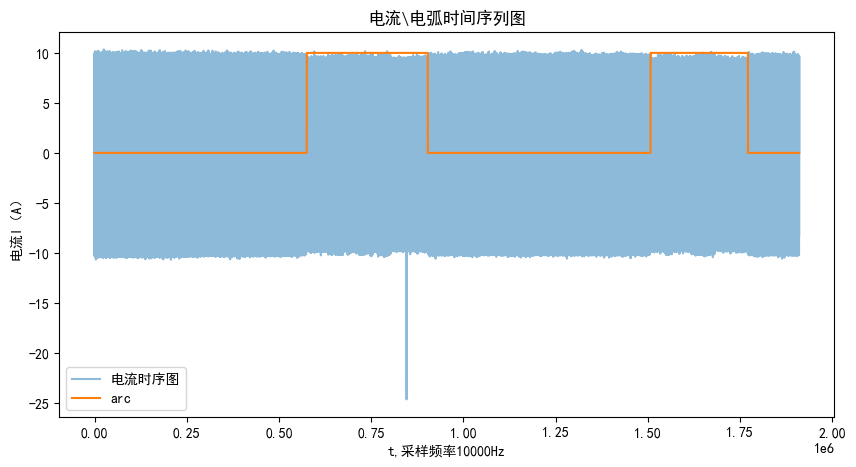

In [9]:
# 电流时序图
U = df.iloc[:,0:window_size]
I = df.iloc[:,window_size:window_size*2]

arc = df['label'].values

plt.figure(figsize=(10,5))
plt.plot(I.values.ravel(),alpha = 0.5,label = '电流时序图')
plt.plot(np.array(sum([[i]*window_size for i in arc],[]))*10,label = 'arc')
plt.xlabel(f't,采样频率{sample_rate}Hz')
plt.ylabel('电流I（A）')
plt.title('电流\电弧时间序列图')
plt.legend()
plt.show()

窗口期数目为：1910


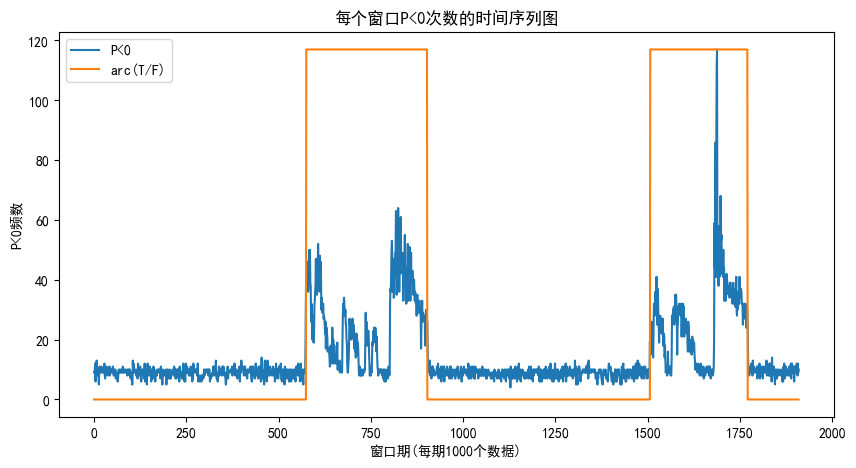

In [10]:
# 从原始数据中提取特征，并做图
P = U.values*I.values
y = np.sum(P<0,axis = 1)
x = range(len(y))
print(f'窗口期数目为：{len(y)}')

plt.figure(figsize=(10,5))
plt.xlabel(f'窗口期(每期{window_size}个数据)')
plt.ylabel('P<0频数')
plt.title('每个窗口P<0次数的时间序列图')
plt.plot(x,y,label = 'P<0')
plt.plot(x,arc*max(y),label = 'arc(T/F)')
plt.legend(loc = 'best')

### 3.5 进行分类并展示结果

#### 3.5.1基于机器学习的方法
---

In [13]:
from ML import ModelTrainer

trainer = ModelTrainer()

X = y.reshape(-1,1)   # 样本
values = arc   # 类别

split_data_tuple = trainer.split_data(X,values)   # 得到X_train,X_test,y_train,y_test
results = trainer.train_and_evaluate(*split_data_tuple)   # 得到accuracy，FPR,FNR等数据
df_results = pd.DataFrame(results)
df_results

,SVM,Decision Tree,Random Forest,KNN,Logistic Regression,Naive Bayes,Gradient Boosting
FPR,0.007380,0.011070,0.011070,0.011070,0.011070,0.011070,0.011070
FNR,0.207207,0.198198,0.198198,0.198198,0.198198,0.198198,0.198198
Precision,0.977778,0.967391,0.967391,0.967391,0.967391,0.967391,0.967391
Recall,0.792793,0.801802,0.801802,0.801802,0.801802,0.801802,0.801802
Accuracy,0.934555,0.934555,0.934555,0.934555,0.934555,0.934555,0.934555
F1,0.875622,0.876847,0.876847,0.876847,0.876847,0.876847,0.876847
F2,0.823970,0.830224,0.830224,0.830224,0.830224,0.830224,0.830224
F0.5,0.934183,0.929019,0.929019,0.929019,0.929019,0.929019,0.929019


##### 3.5.2.2 数据可视化

In [14]:
from Visualization import CPLOT
visual = CPLOT(df_results,index_name='Classifier',value_name='Score')

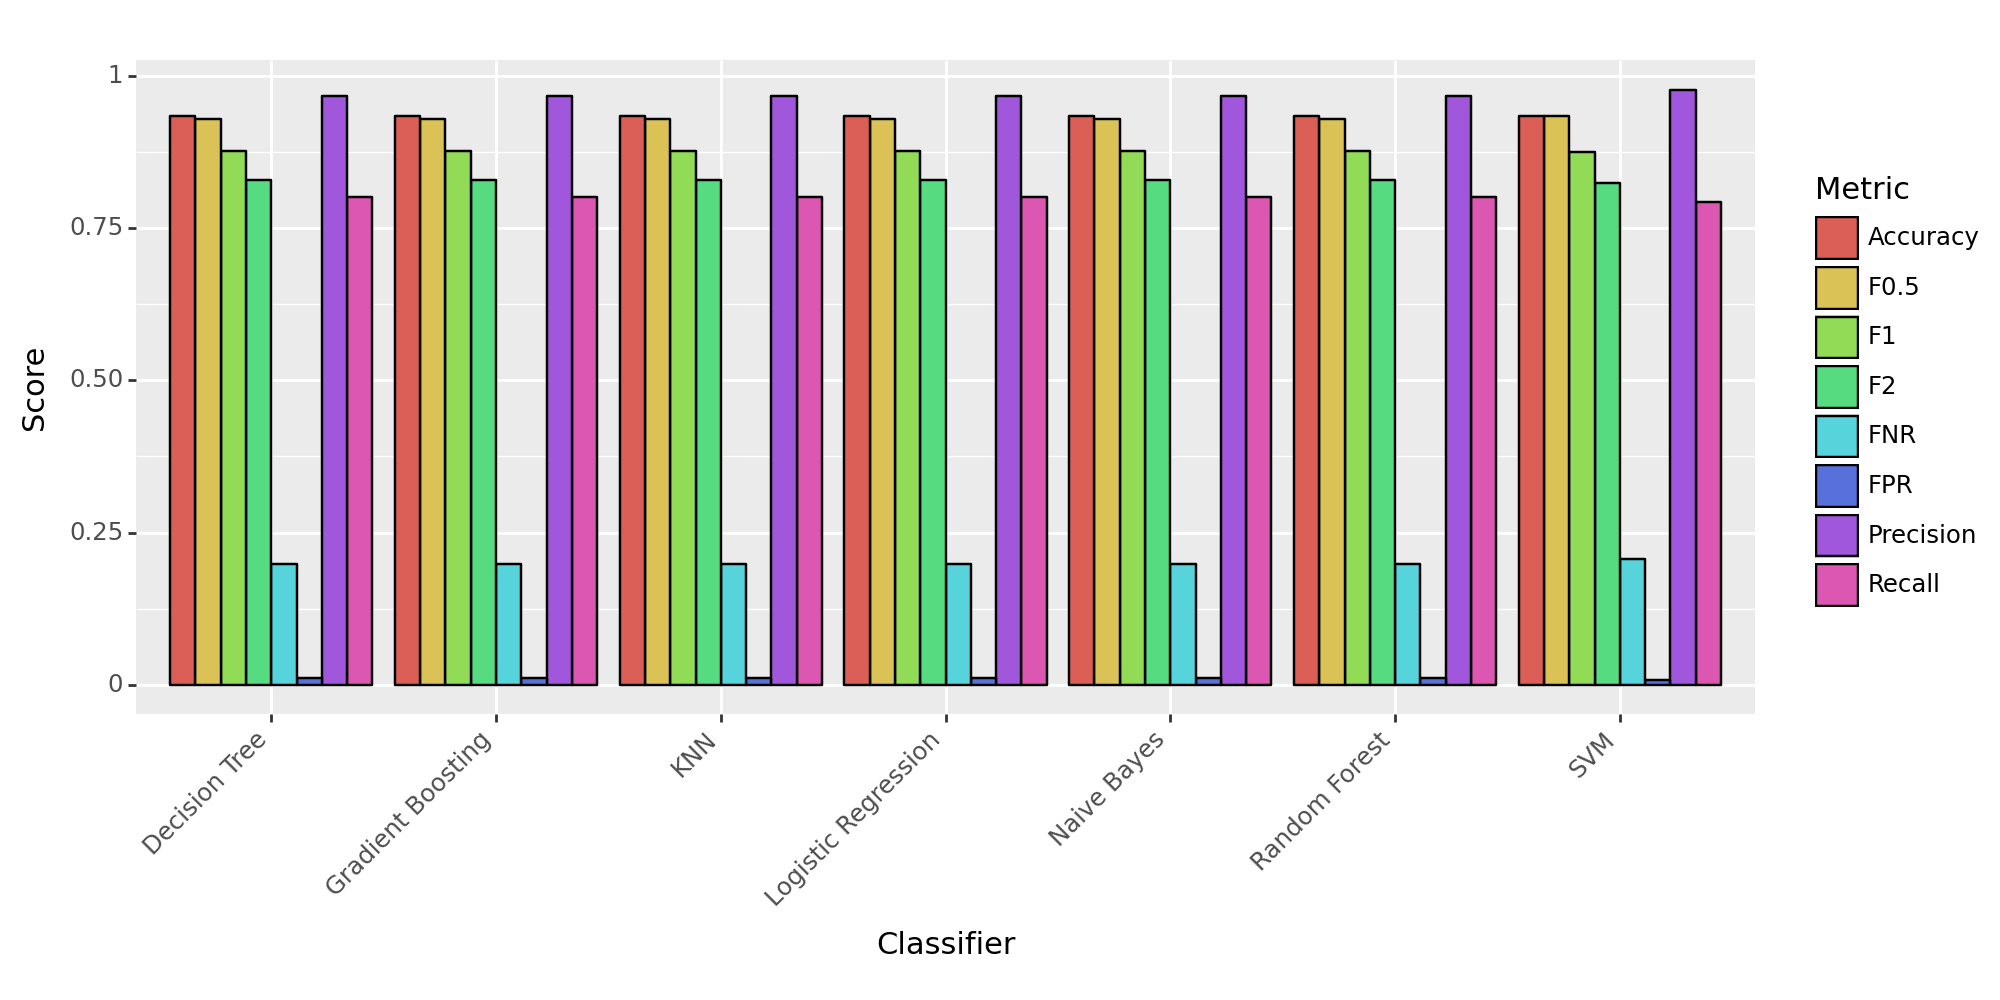

In [15]:
# 复式条形图
visual.multi_bar_plot()

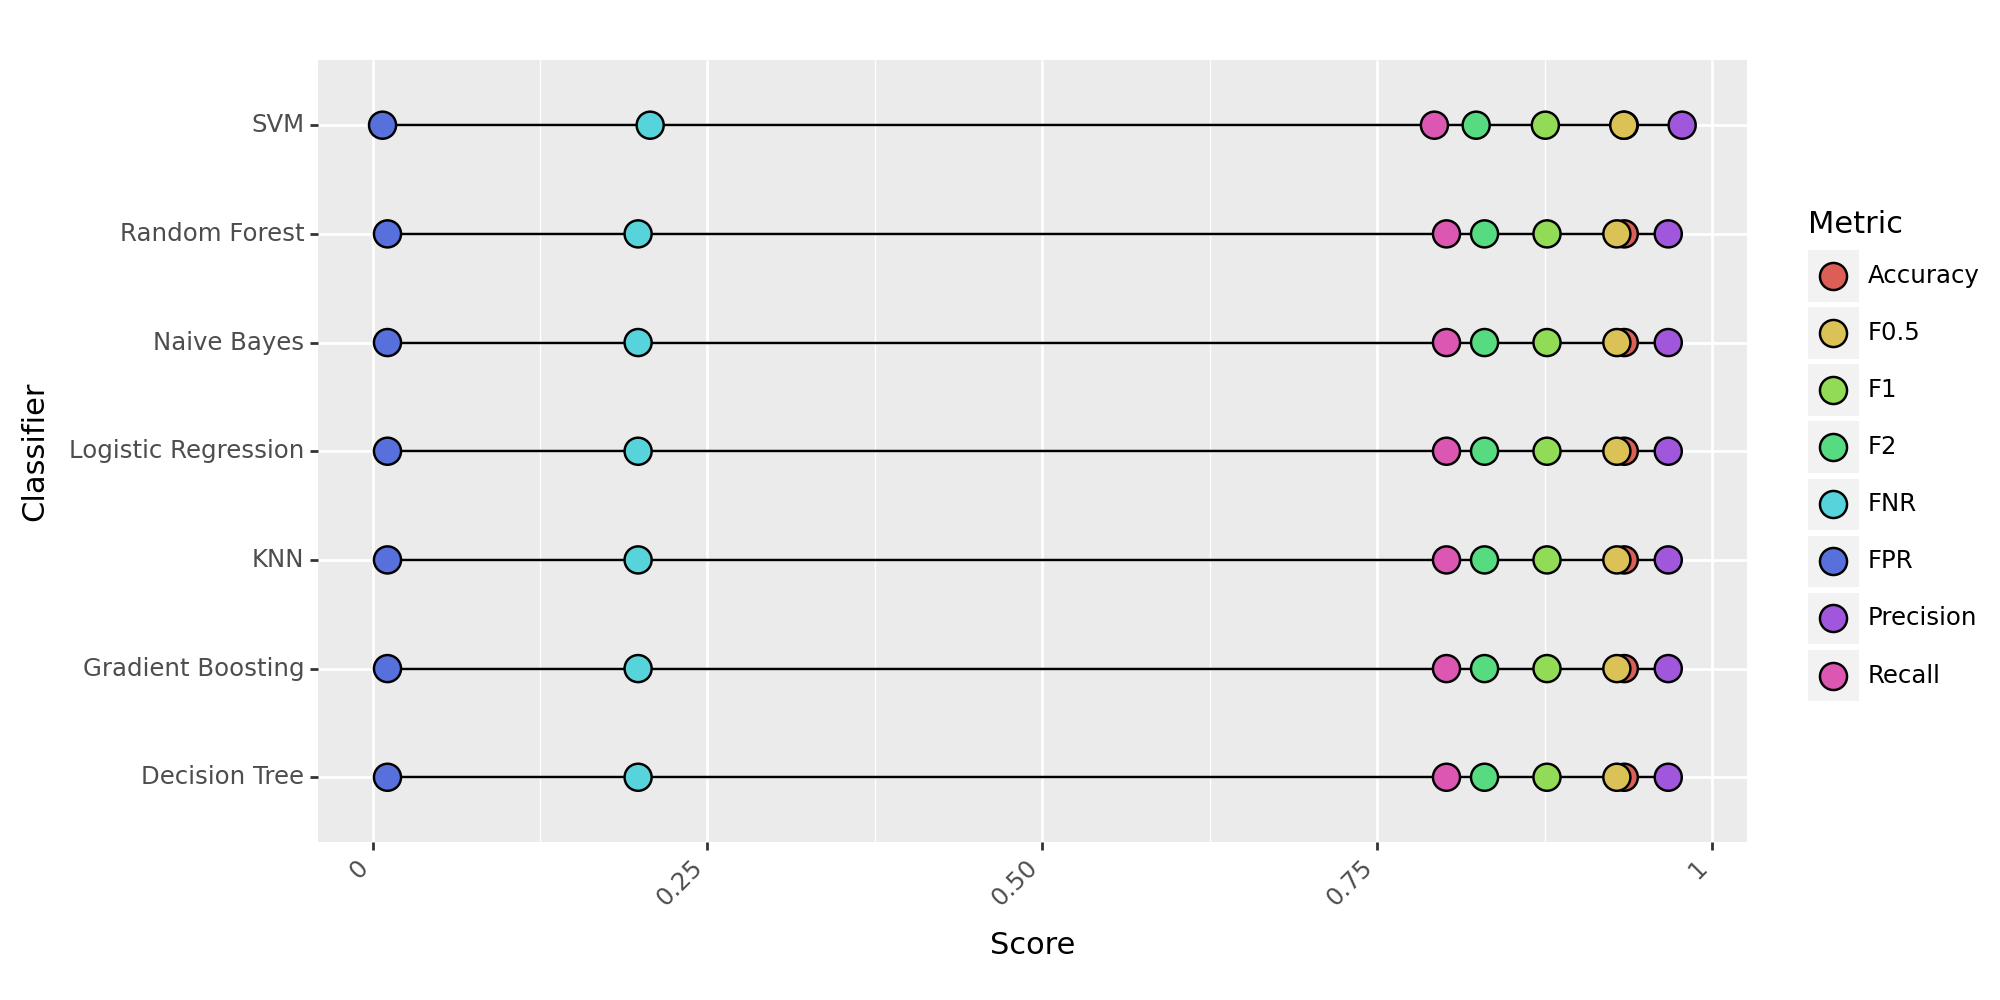

In [16]:
# 克利夫兰图(棒棒糖图)
visual.lollipop_plot()

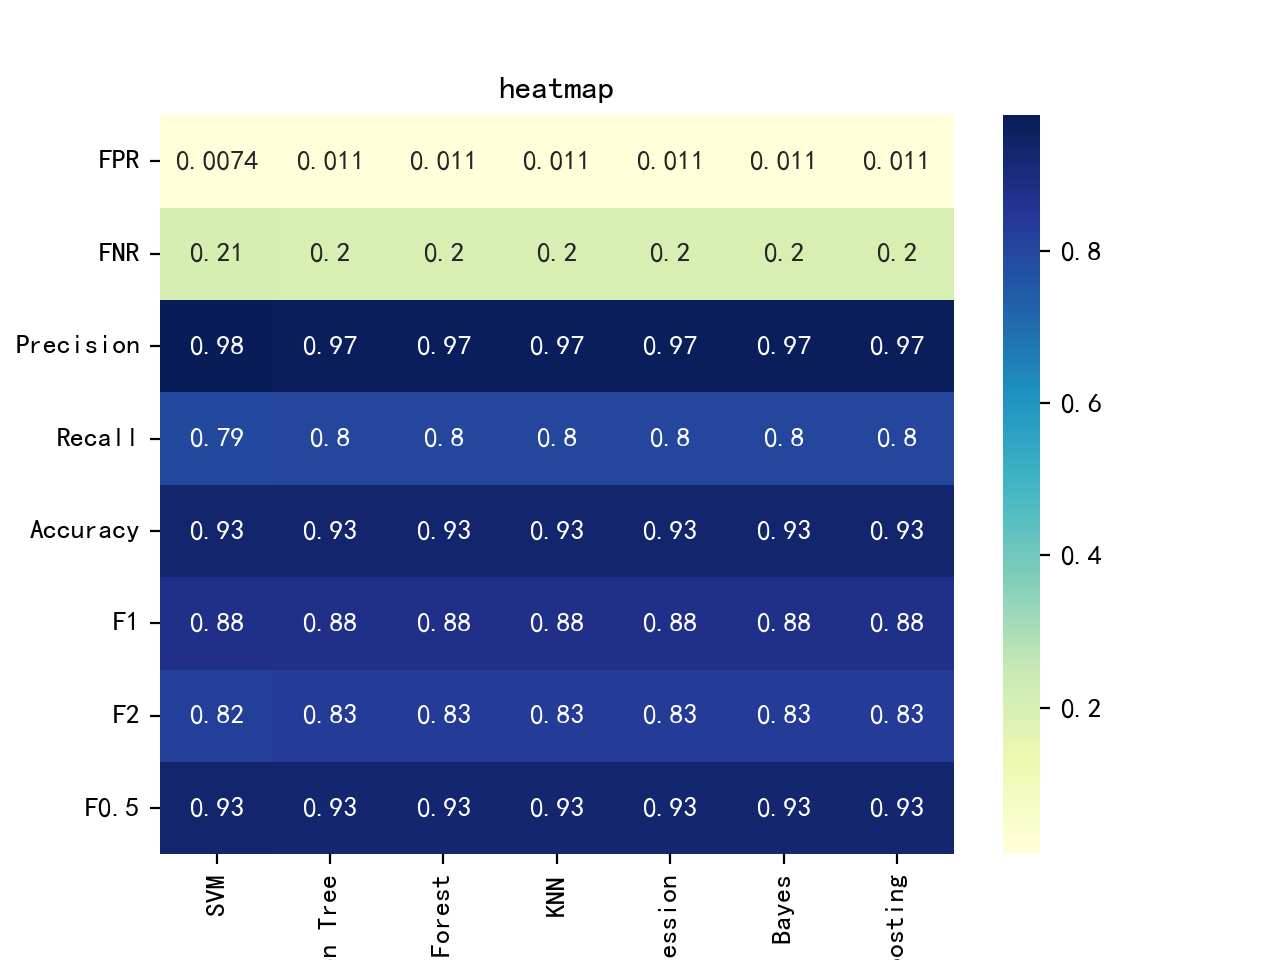

In [17]:
# 热力图
visual.heatmap_plot()

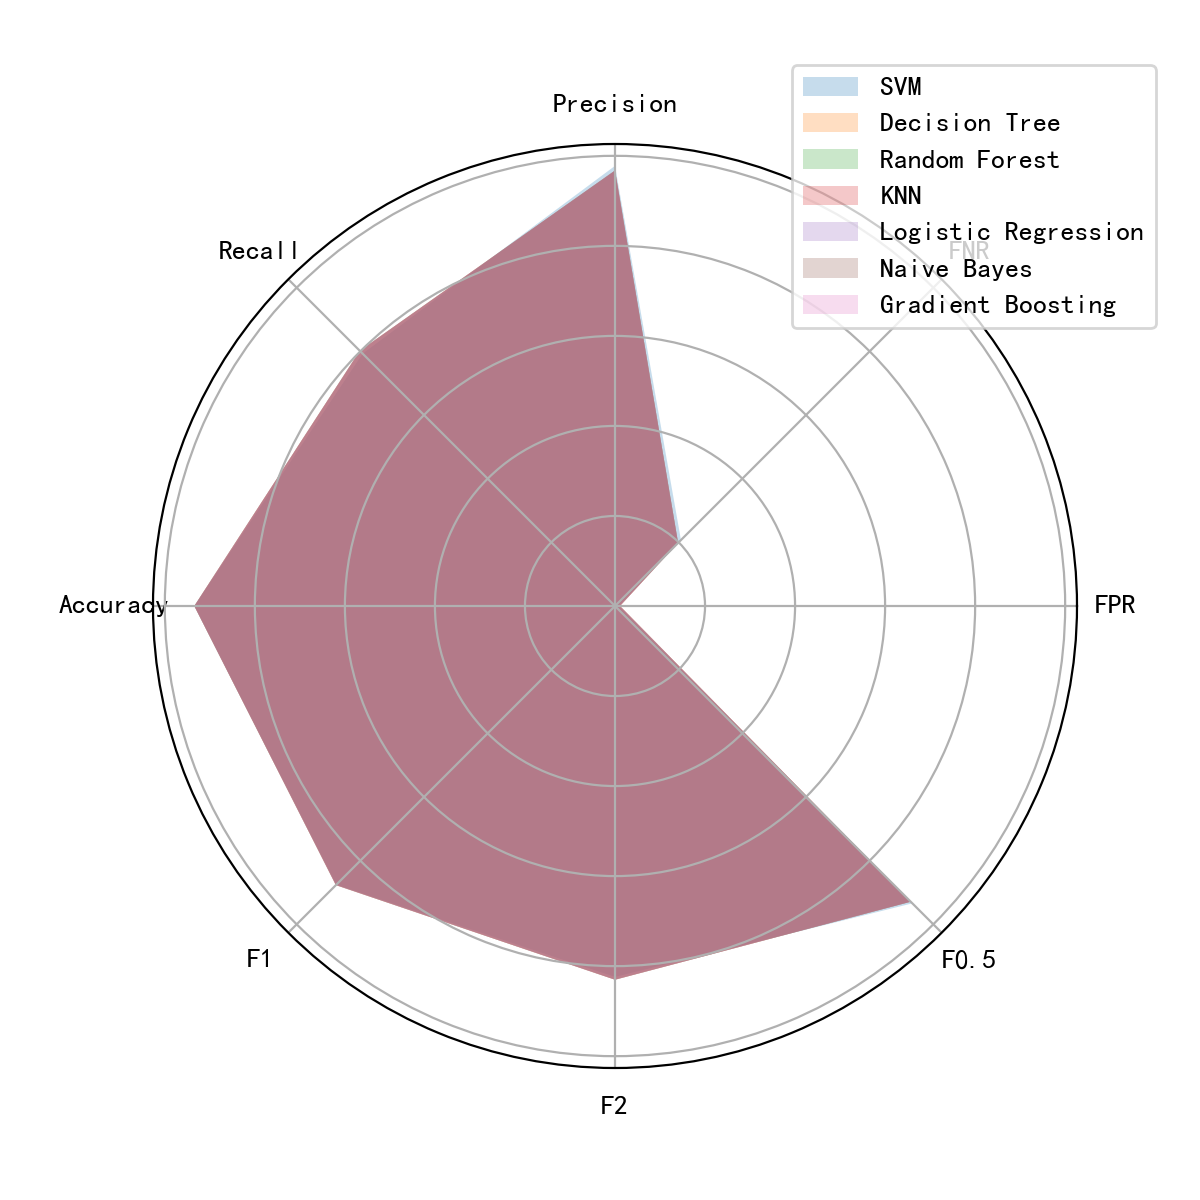

In [18]:
# 南丁格尔玫瑰图
visual.Nightingale_rose_plot()

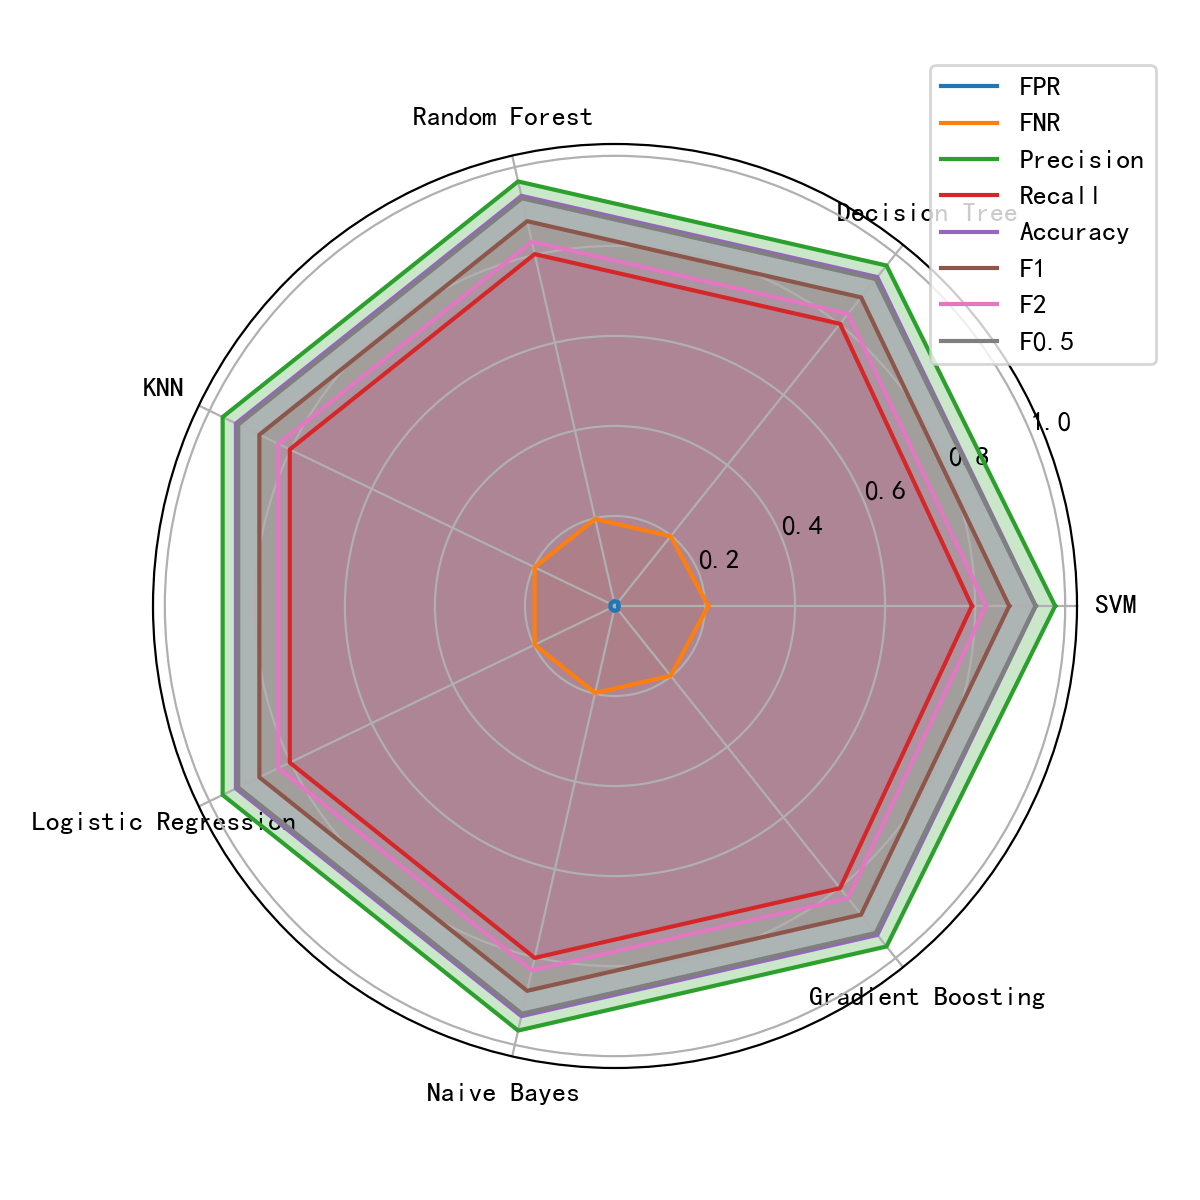

In [19]:
# 绘制雷达图
visual.radar_plot()